In [187]:
import os, math
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

#### show all the audio files

In [2]:
%%bash
ls ~/data/speech_competition/train/audio/yes

004ae714_nohash_0.wav
004ae714_nohash_1.wav
00f0204f_nohash_0.wav
00f0204f_nohash_1.wav
00f0204f_nohash_2.wav
012c8314_nohash_0.wav
0132a06d_nohash_0.wav
0132a06d_nohash_1.wav
0132a06d_nohash_2.wav
0132a06d_nohash_3.wav
0132a06d_nohash_4.wav
0135f3f2_nohash_0.wav
0135f3f2_nohash_1.wav
0137b3f4_nohash_0.wav
0137b3f4_nohash_1.wav
0137b3f4_nohash_2.wav
0137b3f4_nohash_3.wav
0137b3f4_nohash_4.wav
01648c51_nohash_0.wav
01648c51_nohash_1.wav
016e2c6d_nohash_0.wav
019fa366_nohash_0.wav
019fa366_nohash_1.wav
01bb6a2a_nohash_0.wav
01bb6a2a_nohash_1.wav
01bb6a2a_nohash_2.wav
01bb6a2a_nohash_3.wav
01bb6a2a_nohash_4.wav
01bcfc0c_nohash_0.wav
01d22d03_nohash_0.wav
01d22d03_nohash_1.wav
01d22d03_nohash_2.wav
022cd682_nohash_0.wav
023808be_nohash_0.wav
023a61ad_nohash_0.wav
023a61ad_nohash_1.wav
023a61ad_nohash_2.wav
026290a7_nohash_0.wav
02fcd241_nohash_0.wav
035de8fe_nohash_0.wav
0362539c_nohash_0.wav
0397ecda_nohash_0.wav
03c96658_nohash_0.wav
03cf93b1_nohash_0.wav
03cf93b1_nohash_1.wav
042186b8_n

#### read audio files as `samples` and associated `sample_rate`

In [39]:
folder_path = '/Users/matt.meng/data/speech_competition/train/audio'
#file_path = 'go/016e2c6d_nohash_3.wav'

#file_path = 'yes/05b2db80_nohash_0.wav'
file_path = 'yes/06a79a03_nohash_2.wav'
#file_path = 'yes/079d1020_nohash_0.wav'
wave_file_path = os.path.join(folder_path, file_path)

In [40]:
sample_rate, samples = wavfile.read(wave_file_path)

In [41]:
print samples.shape, sample_rate
print 'duration: {} second'.format(samples.shape[0] / sample_rate)

(16000,) 16000
duration: 1 second


#### shrink the sample size

In [42]:
#samples = samples[4000:12000]

In [43]:
def plot_waveform(samples_):
    fig = plt.figure(figsize=(12, 3), dpi=200)
    plt.plot(samples_)
    fig.suptitle('raw waveform', fontsize=15)
    plt.xlabel('sample#', fontsize=12)
    plt.ylabel('amplitude', fontsize=12)

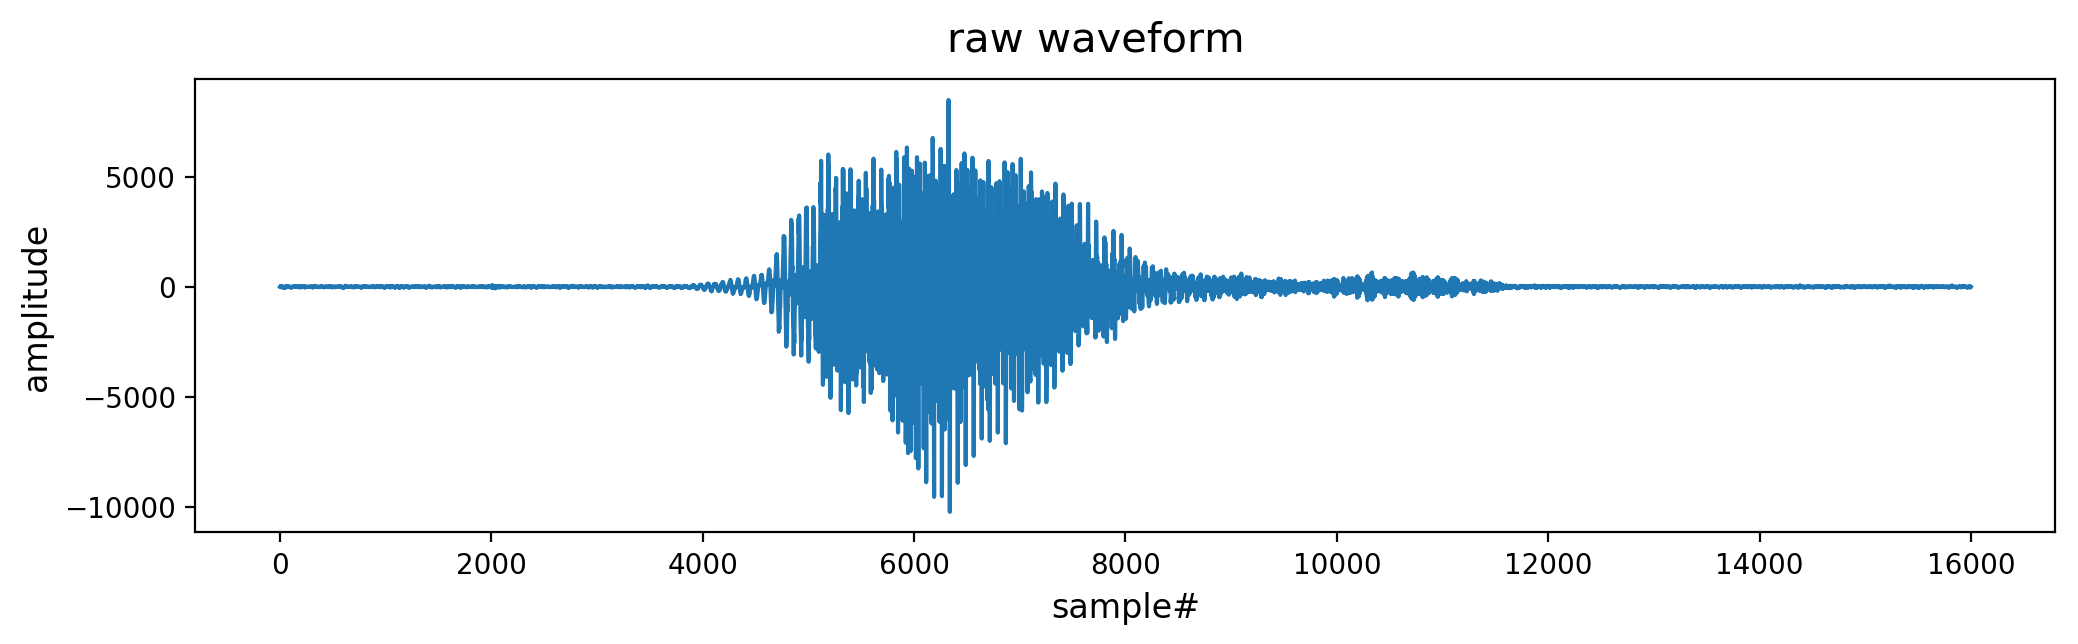

In [44]:
plot_waveform(samples)

#### play the audio

In [45]:
ipd.Audio(samples, rate=sample_rate)

#### function to emphasize the signal

In [46]:
def emphasize_signal(samples, pre_emphasis=0.97):
    ## y[t] = x[t] - pre_emphasis * x[t-1]
    return np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])


In [47]:
emphasized_signal = emphasize_signal(samples)

In [50]:
#plot_waveform(emphasized_signal)

In [49]:
#ipd.Audio(emphasized_signal, rate=sample_rate)

In [58]:
frame_size = 0.025 # in seconds
frame_stride = 0.01 # in seconds

frame_length = int(round(frame_size * sample_rate))
frame_step = int(round(frame_stride * sample_rate))

signal_length = len(emphasized_signal)
num_frames = int(math.ceil(1.*(signal_length - frame_length) / frame_step))

#### pad the signal with zeros

In [60]:
padded_signal_length = num_frames * frame_step + frame_length
padded_signal = np.append(emphasized_signal, np.zeros(padded_signal_length - signal_length))

#### build the feature matrix

In [82]:
# common index as np.arange(0, frame_length) for all frames
base_index = np.tile(np.arange(0, frame_length), (num_frames, 1)) 
# for each i-th frame, this index is i * frame_step
frame_based_index = np.tile(np.arange(0, num_frames*frame_step, frame_step), (frame_length, 1)).T
indices = base_index + frame_based_index

In [83]:
frames = padded_signal[indices]

#### use the `hamming` window function

In [86]:
frames = frames * np.hamming(frame_length)

In [89]:
print frames.shape

(98, 400)


#### Fast-Fourier Transformation

In [90]:
NFFT = 512
# power spectrum
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
power_frames = 1. / NFFT * np.square(mag_frames)

In [92]:
print mag_frames.shape, power_frames.shape

(98, 257) (98, 257)


#### build the bank filter

In [158]:
def mel2freq(mel):
    return 700 * (math.exp(1.*mel/1125) - 1)

def freq2mel(freq):
    return 1125*math.log(1 + 1.*freq/700)

def freq2binIndex_generator(bin_num, max_freq):
    def _freq2binIndex(freq):
        return np.floor(1.*freq/(max_freq+1)*bin_num)
    return _freq2binIndex

# create a function to map frequency to corresponding FFT bin number
freq2binIndex = freq2binIndex_generator(mag_frames.shape[1], sample_rate/2)

In [159]:
assert int(freq2mel(300)) == 401
assert int(freq2mel(8000)) == 2834

In [160]:
num_filters = 40
low_freq_mel = 0
high_freq_mel = freq2mel(sample_rate/2)
mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters+2)
freq_points = map(mel2freq, mel_points)
bins = map(freq2binIndex, freq_points)

In [163]:
assert np.isclose(mel2freq(freq2mel(sample_rate/2)), sample_rate/2)

In [168]:
len(bins)

42

#### create the fileter banks

In [165]:
fbank = np.zeros([num_filters, int(NFFT / 2 + 1)])

In [171]:
for i in range(num_filters):
    # the rising edge of triangle filter
    for j in range(int(bins[i]), int(bins[i+1])):
        fbank[i, j] = (1.*j - bins[i]) / (bins[i+1] - bins[i])
    # the falling edge
    for j in range(int(bins[i+1]), int(bins[i+2])):
        fbank[i, j] = (bins[i+2] - 1.*j) / (bins[i+2] - bins[i+1])

In [173]:
fbank[39]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

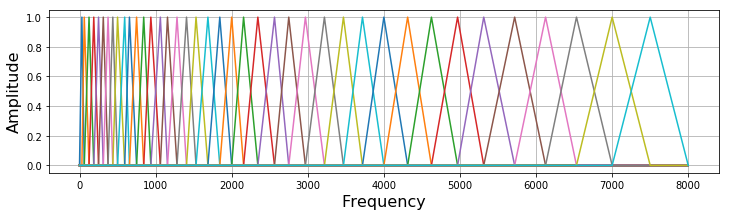

In [177]:
plt.figure(figsize=(12, 3))
plt.plot(np.linspace(low_freq_mel, (sample_rate / 2), int(NFFT/2+1)), fbank.T)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Frequency', fontsize=16)
plt.grid(True)
plt.savefig('mel_filters.jpg', bbox_inches='tight', dpi=200)
plt.show()

#### create the filter banks, the power spectrum

In [180]:
# Features
filter_banks = np.dot(power_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [182]:
filter_banks.shape

(98, 40)

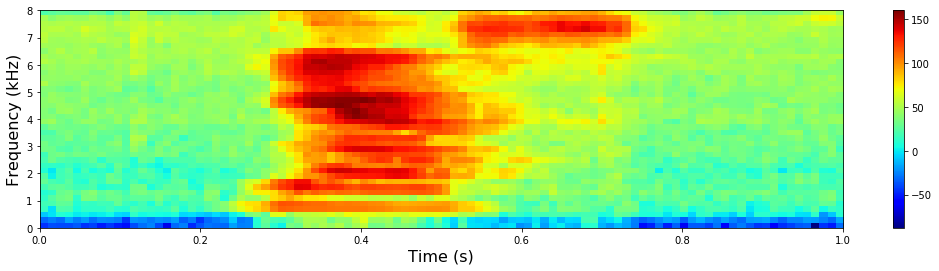

In [198]:
fig, ax = plt.subplots(figsize=(18, 4))
plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect='auto', extent=[0, 1., 0, sample_rate/2/1000])
plt.colorbar()
plt.ylabel('Frequency (kHz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
